In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
data=sio.loadmat('ex4data1.mat')
raw_X=data['X']
raw_y=data['y']

In [4]:
X=np.insert(raw_X,0,values=1,axis=1)
X.shape

(5000, 401)

### One-hot编码
每个样本中只有一个特征状态为1，其余为0

In [5]:
def one_hot_encoder(raw_y):
    result=[]
    for i in raw_y:#y的值1-10
        y_temp=np.zeros(10)
        y_temp[i-1]=1
        result.append(y_temp)
    return np.array(result)

In [6]:
y=one_hot_encoder(raw_y)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], shape=(5000, 10))

In [7]:
theta=sio.loadmat('ex4weights.mat')
theta1,theta2=theta['Theta1'],theta['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

### 序列化权重参数
序列化：把模型的参数（比如权重和偏置）以二进制的形式保存到文件中。

反序列化：把保存的数据再次读取出来。

In [8]:
def serialize(a,b):
    return np.append(a.flatten(),b.flatten())

In [9]:
theta_serialize=serialize(theta1,theta2)
theta_serialize.shape

(10285,)

### 解序列化权重参数

In [10]:
def deserialize(theta_serialize):
    theta1=theta_serialize[:25*401].reshape(25,401)
    theta2=theta_serialize[25*401:].reshape(10,26)
    return theta1,theta2

In [11]:
theta1,theta2=deserialize(theta_serialize)

In [12]:
theta1.shape,theta2.shape

((25, 401), (10, 26))

### 前向传播
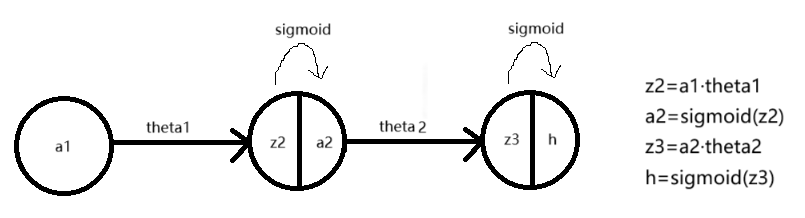

In [13]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [14]:
def feed_forword(theta_serialize,X):
    theta1,theta2=deserialize(theta_serialize)
    a1=X
    z2=a1@theta1.T
    a2=sigmoid(z2)
    a2=np.insert(a2,0,values=1,axis=1)
    z3=a2@theta2.T
    h=sigmoid(z3)
    return a1,z2,a2,z3,h

### 损失函数
#### 1.不带正则化的损失函数

In [15]:
def cost(theta_serialize,X,y):
    a1,z2,a2,z3,h=feed_forword(theta_serialize,X)
    J=-np.sum(y*np.log(h)+(1-y)*np.log(1-h))/len(X)
    return J

In [16]:
cost(theta_serialize,X,y)

np.float64(0.2876291651613189)

#### 2.带正则化的损失函数

In [17]:
def reg_cost(theta_serialize,X,y,lamda):
    sum1=np.sum(np.power(theta1[:,1:],2))
    sum2=np.sum(np.power(theta2[:,1:],2))
    reg=(sum1+sum2)*lamda/2/len(X)
    return reg+cost(theta_serialize,X,y)

In [18]:
lamda=1
reg_cost(theta_serialize,X,y,lamda)

np.float64(0.38376985909092365)

### 反向传播
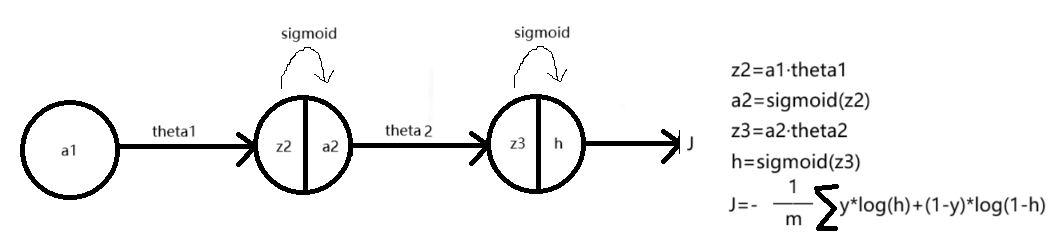
#### 1.不带正则化的梯度
$$
sigmoid=\frac 1 {1+e^{-z}}  
$$
$$
sigmoid\ '=sigmoid*(1-sigmoid)
$$

$$
\frac{\partial J}{\partial \theta_2}=\frac{\partial J}{\partial h}·\frac{\partial h}{\partial z3}·\frac{\partial z3}{\partial \theta_2}
=(h-y)*a2
$$

$$
\frac{\partial J}{\partial \theta_1}=\frac{\partial J}{\partial h}·\frac{\partial h}{\partial z3}·\frac{\partial z3}{\partial a2}·\frac{\partial a2}{\partial z2}·\frac{\partial z2}{\partial \theta_1}
=(h-y)*\theta_2*sigmoid(z2)\ '*a1
$$

In [19]:
def sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [21]:
def gradient(theta_serialize,X,y):
    theta1,theta2=deserialize(theta_serialize)
    a1,z2,a2,z3,h=feed_forword(theta_serialize,X)

    d3=h-y
    d2=d3@theta2[:,1:]*sigmoid_gradient(z2)
    D2=(d3.T@a2)/len(X)
    D1=(d2.T@a1)/len(X)
    return serialize(D1,D2)

#### 2.带正则化的梯度

In [23]:
def reg_gradient(theta_serialize,X,y,lamda):
    D=gradient(theta_serialize,X,y)
    D1,D2=deserialize(D)

    theta1,theta2=deserialize(theta_serialize)
    D1[:,1:]= D1[:,1:]+theta1[:,1:]*lamda/len(X)
    D2[:,1:]= D2[:,1:]+theta2[:,1:]*lamda/len(X)
    return serialize(D1,D2)

### 神经网络优化

In [38]:
from scipy.optimize import minimize
def nn_training(X,y):
    init_theta=np.random.uniform(-0.5,0.5,10285)
    res=minimize(
         fun=reg_cost,
         x0=init_theta,
         args=(X,y,lamda),
         method='TNC',
         jac=reg_gradient,
         options={'maxfun':300})
    return res 

In [39]:
lamda=10
res=nn_training(X,y)

In [40]:
raw_y=data['y'].reshape(5000,)

In [41]:
_,_,_,_,h=feed_forword(res.x,X)
y_pred=np.argmax(h,axis=1)+1
acc=np.mean(y_pred==raw_y)
acc

np.float64(0.9366)

### 可视化隐藏层

In [45]:
def plot_hidden_layer(theta):
    theta1,_=deserialize(theta)
    hidden_layer=theta1[:,1:]#不要自己添加的偏置项 25，400

    fig,ax=plt.subplots(ncols=5,nrows=5,figsize=(8,8),sharex=True,sharey=True)
    for r in range(5):
        for c in range(5):
            ax[r,c].imshow(hidden_layer[5*r+c].reshape(20,20).T,cmap='gray_r')

    plt.xticks([])
    plt.yticks([])
    plt.show

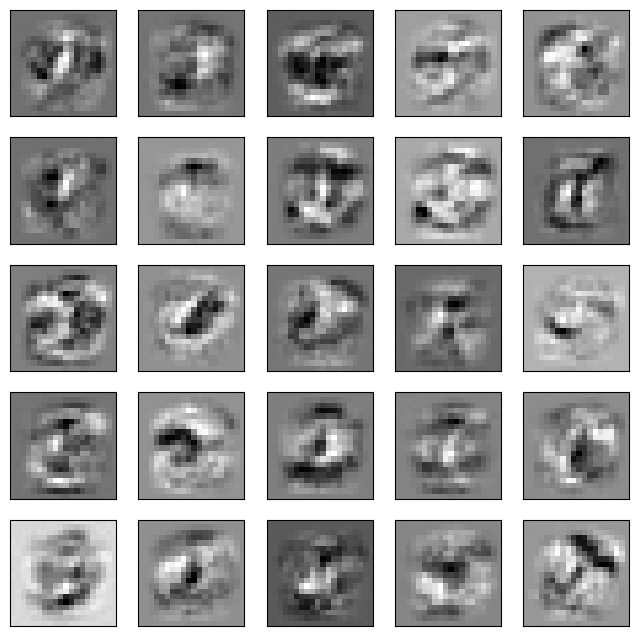

In [46]:
plot_hidden_layer(res.x)